# Dataset Report & Preprocessing

*Ethical Risk:* Data on corruption and institutions often rely on subjective indices, this leads to systematic distortions.

*Mitigation Strategy:* Use multiple internationally recognized sources (CPI, Political Corruption Index).

*Trade-off:* Expanding sources reduces bias but increases noise and reduces the purity of signals. This can reduce accuracy, but will improve robustness and fairness when comparing countries.



# Load the datasets and merge them


**Some data can be lost during merging datasets because of different country naming, for example: 
United States / United States of America / USA**

Therefore, we need to standartize naming before merging

Let's scan the datasets and find if we can fill missing values 

In [3]:
import pandas as pd
import numpy as np
import re

print("Loading datasets with error handling...")

# Load datasets with different approaches
try:
    internet_use = pd.read_csv('../data/raw/Internet-use.csv')
    print(f"✓ Internet use loaded: {internet_use.shape}")
except Exception as e:
    print(f"✗ Internet use error: {e}")

try:
    press_freedom = pd.read_csv('../data/raw/Press-freedom.csv')
    print(f"✓ Press freedom loaded: {press_freedom.shape}")
except Exception as e:
    print(f"✗ Press freedom error: {e}")

try:
    # GDP per capita might have header issues, let's skip first few rows
    gdp_per_capita = pd.read_csv('../data/raw/Gdp-per-capita.csv', skiprows=4)
    print(f"✓ GDP per capita loaded: {gdp_per_capita.shape}")
except Exception as e:
    print(f"✗ GDP per capita error: {e}")

try:
    # Inflation might have similar issues
    inflation = pd.read_csv('../data/raw/Inflation.csv', skiprows=4)
    print(f"✓ Inflation loaded: {inflation.shape}")
except Exception as e:
    print(f"✗ Inflation error: {e}")

try:
    resources = pd.read_csv('../data/raw/Resources.csv')
    print(f"✓ Resources loaded: {resources.shape}")
except Exception as e:
    print(f"✗ Resources error: {e}")

try:
    political_corruption = pd.read_csv('../data/raw/political-corruption-index.csv')
    print(f"✓ Political corruption loaded: {political_corruption.shape}")
except Exception as e:
    print(f"✗ Political corruption error: {e}")

try:
    avg_schooling = pd.read_csv('../data/raw/average-years-of-schooling.csv')
    print(f"✓ Average schooling loaded: {avg_schooling.shape}")
except Exception as e:
    print(f"✗ Average schooling error: {e}")

try:
    ti_corruption = pd.read_csv('../data/raw/ti-corruption-perception-index.csv')
    print(f"✓ TI corruption loaded: {ti_corruption.shape}")
except Exception as e:
    print(f"✗ TI corruption error: {e}")

print("\n" + "="*50)
print("Examining successfully loaded datasets...")

# Check what we have
if 'internet_use' in locals():
    print(f"\nInternet use columns: {internet_use.columns.tolist()}")
    print(f"Sample countries: {internet_use['Country Name'].head().tolist()}")

if 'gdp_per_capita' in locals():
    print(f"\nGDP per capita columns: {gdp_per_capita.columns.tolist()}")
    print(f"Sample countries: {gdp_per_capita['Country Name'].head().tolist()}")

if 'political_corruption' in locals():
    print(f"\nPolitical corruption columns: {political_corruption.columns.tolist()}")
    print(f"Sample countries: {political_corruption['Entity'].head().tolist()}")

if 'avg_schooling' in locals():
    print(f"\nAverage schooling columns: {avg_schooling.columns.tolist()}")
    print(f"Sample countries: {avg_schooling['Entity'].head().tolist()}")

if 'ti_corruption' in locals():
    print(f"\nTI corruption columns: {ti_corruption.columns.tolist()}")
    print(f"Sample countries: {ti_corruption['Entity'].head().tolist()}")

if 'resources' in locals():
    print(f"\nResources columns: {resources.columns.tolist()}")
    print(f"Sample countries: {resources['Country Name'].head().tolist()}")
    # Check what series are available in resources
    if 'Series Name' in resources.columns:
        print(f"Available series in resources: {resources['Series Name'].unique()}")

if 'press_freedom' in locals():
    print(f"\nPress freedom columns: {press_freedom.columns.tolist()}")
    if 'REF_AREA_NAME' in press_freedom.columns:
        print(f"Sample countries: {press_freedom['REF_AREA_NAME'].head().tolist()}")
    elif 'Entity' in press_freedom.columns:
        print(f"Sample countries: {press_freedom['Entity'].head().tolist()}")

if 'inflation' in locals():
    print(f"\nInflation columns: {inflation.columns.tolist()}")
    print(f"Sample countries: {inflation['Country Name'].head().tolist()}")

Loading datasets with error handling...
✓ Internet use loaded: (271, 18)
✓ Press freedom loaded: (45204, 38)
✓ GDP per capita loaded: (266, 70)
✓ Inflation loaded: (266, 70)
✓ Resources loaded: (1601, 30)
✓ Political corruption loaded: (28614, 5)
✓ Average schooling loaded: (6839, 5)
✓ TI corruption loaded: (2404, 5)

Examining successfully loaded datasets...

Internet use columns: ['Series Name', 'Series Code', 'Country Name', 'Country Code', '2011 [YR2011]', '2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]', '2022 [YR2022]', '2023 [YR2023]', '2024 [YR2024]']
Sample countries: ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra']

GDP per capita columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976',

In [5]:
# Function to standardize country names
def standardize_country_name(name):
    """Standardize country names to a common format"""
    if pd.isna(name):
        return name
    
    # Convert to string and strip whitespace
    name = str(name).strip()
    
    # Common standardizations
    standardizations = {
        'United States of America': 'United States',
        'USA': 'United States',
        'US': 'United States',
        'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
        'UK': 'United Kingdom',
        'Russian Federation': 'Russia',
        'Korea, Rep.': 'South Korea',
        'Korea, Democratic People\'s Republic of': 'North Korea',
        'Iran, Islamic Rep.': 'Iran',
        'Egypt, Arab Rep.': 'Egypt',
        'Venezuela, RB': 'Venezuela',
        'Syrian Arab Republic': 'Syria',
        'Yemen, Rep.': 'Yemen',
        'Congo, Rep.': 'Republic of Congo',
        'Congo, Dem. Rep.': 'Democratic Republic of Congo',
        'Lao PDR': 'Laos',
        'Slovak Republic': 'Slovakia',
        'Czech Republic': 'Czechia',
        'Kyrgyz Republic': 'Kyrgyzstan',
        'Gambia, The': 'Gambia',
        'Bahamas, The': 'Bahamas',
        'Cabo Verde': 'Cape Verde',
        'Cote d\'Ivoire': 'Ivory Coast',
        'Turkiye': 'Turkey',
        'Türkiye': 'Turkey'
    }
    
    return standardizations.get(name, name)

# Process each dataset
print("Processing datasets...")

# 1. Internet Use - reshape from wide to long format
print("1. Processing Internet Use data...")
internet_long = pd.melt(internet_use, 
                       id_vars=['Country Name', 'Country Code'], 
                       value_vars=[col for col in internet_use.columns if '[YR' in col],
                       var_name='Year_Col', value_name='Internet_Usage_Pct')
internet_long['Year'] = internet_long['Year_Col'].str.extract(r'(\d{4})').astype(int)
internet_long = internet_long[['Country Name', 'Year', 'Internet_Usage_Pct']].copy()
internet_long['Country Name'] = internet_long['Country Name'].apply(standardize_country_name)
internet_long = internet_long.dropna(subset=['Internet_Usage_Pct'])
internet_long['Internet_Usage_Pct'] = pd.to_numeric(internet_long['Internet_Usage_Pct'], errors='coerce')
print(f"Internet use processed: {internet_long.shape}")

# 2. GDP per capita - reshape from wide to long format
print("2. Processing GDP per capita data...")
gdp_long = pd.melt(gdp_per_capita, 
                   id_vars=['Country Name', 'Country Code'], 
                   value_vars=[str(year) for year in range(1990, 2025) if str(year) in gdp_per_capita.columns],
                   var_name='Year', value_name='GDP_Per_Capita_PPP')
gdp_long['Year'] = gdp_long['Year'].astype(int)
gdp_long = gdp_long[['Country Name', 'Year', 'GDP_Per_Capita_PPP']].copy()
gdp_long['Country Name'] = gdp_long['Country Name'].apply(standardize_country_name)
gdp_long = gdp_long.dropna(subset=['GDP_Per_Capita_PPP'])
gdp_long['GDP_Per_Capita_PPP'] = pd.to_numeric(gdp_long['GDP_Per_Capita_PPP'], errors='coerce')
print(f"GDP per capita processed: {gdp_long.shape}")

# 3. Inflation - reshape from wide to long format
print("3. Processing Inflation data...")
inflation_long = pd.melt(inflation, 
                        id_vars=['Country Name', 'Country Code'], 
                        value_vars=[str(year) for year in range(1990, 2025) if str(year) in inflation.columns],
                        var_name='Year', value_name='Inflation_Rate')
inflation_long['Year'] = inflation_long['Year'].astype(int)
inflation_long = inflation_long[['Country Name', 'Year', 'Inflation_Rate']].copy()
inflation_long['Country Name'] = inflation_long['Country Name'].apply(standardize_country_name)
inflation_long = inflation_long.dropna(subset=['Inflation_Rate'])
inflation_long['Inflation_Rate'] = pd.to_numeric(inflation_long['Inflation_Rate'], errors='coerce')
print(f"Inflation processed: {inflation_long.shape}")

# 4. Resources - filter for total natural resources and reshape
print("4. Processing Resources data...")
resources_total = resources[resources['Series Name'] == 'Total natural resources rents (% of GDP)'].copy()
resources_long = pd.melt(resources_total, 
                        id_vars=['Country Name', 'Country Code'], 
                        value_vars=[col for col in resources_total.columns if '[YR' in col],
                        var_name='Year_Col', value_name='Natural_Resources_Rent_Pct_GDP')
resources_long['Year'] = resources_long['Year_Col'].str.extract(r'(\d{4})').astype(int)
resources_long = resources_long[['Country Name', 'Year', 'Natural_Resources_Rent_Pct_GDP']].copy()
resources_long['Country Name'] = resources_long['Country Name'].apply(standardize_country_name)
resources_long = resources_long.dropna(subset=['Natural_Resources_Rent_Pct_GDP'])
resources_long['Natural_Resources_Rent_Pct_GDP'] = pd.to_numeric(resources_long['Natural_Resources_Rent_Pct_GDP'], errors='coerce')
print(f"Resources processed: {resources_long.shape}")

# 5. Political Corruption Index
print("5. Processing Political Corruption data...")
political_corruption_clean = political_corruption[['Entity', 'Year', 'Political corruption index (central estimate)']].copy()
political_corruption_clean.columns = ['Country Name', 'Year', 'Political_Corruption_Index']
political_corruption_clean['Country Name'] = political_corruption_clean['Country Name'].apply(standardize_country_name)
political_corruption_clean = political_corruption_clean.dropna(subset=['Political_Corruption_Index'])
print(f"Political corruption processed: {political_corruption_clean.shape}")

# 6. Average Years of Schooling
print("6. Processing Average Schooling data...")
avg_schooling_clean = avg_schooling[['Entity', 'Year', 'Average years of schooling']].copy()
avg_schooling_clean.columns = ['Country Name', 'Year', 'Average_Years_Schooling']
avg_schooling_clean['Country Name'] = avg_schooling_clean['Country Name'].apply(standardize_country_name)
avg_schooling_clean = avg_schooling_clean.dropna(subset=['Average_Years_Schooling'])
print(f"Average schooling processed: {avg_schooling_clean.shape}")

# 7. TI Corruption Perception Index
print("7. Processing TI Corruption data...")
ti_corruption_clean = ti_corruption[['Entity', 'Year', 'Corruption Perceptions Index']].copy()
ti_corruption_clean.columns = ['Country Name', 'Year', 'TI_Corruption_Perception_Index']
ti_corruption_clean['Country Name'] = ti_corruption_clean['Country Name'].apply(standardize_country_name)
ti_corruption_clean = ti_corruption_clean.dropna(subset=['TI_Corruption_Perception_Index'])
print(f"TI corruption processed: {ti_corruption_clean.shape}")

# 8. Press Freedom - this one is more complex, let's examine it further
print("8. Processing Press Freedom data...")
# Filter for relevant press freedom indicators
press_freedom_filtered = press_freedom[
    (press_freedom['INDICATOR_NAME'].str.contains('Press Freedom', case=False, na=False)) |
    (press_freedom['INDICATOR_NAME'].str.contains('Media', case=False, na=False))
].copy()

if len(press_freedom_filtered) > 0:
    press_freedom_clean = press_freedom_filtered[['REF_AREA_NAME', 'TIME_PERIOD', 'OBS_VALUE']].copy()
    press_freedom_clean.columns = ['Country Name', 'Year', 'Press_Freedom_Score']
    press_freedom_clean['Country Name'] = press_freedom_clean['Country Name'].apply(standardize_country_name)
    press_freedom_clean = press_freedom_clean.dropna(subset=['Press_Freedom_Score'])
    press_freedom_clean['Press_Freedom_Score'] = pd.to_numeric(press_freedom_clean['Press_Freedom_Score'], errors='coerce')
    print(f"Press freedom processed: {press_freedom_clean.shape}")
else:
    print("No suitable press freedom indicators found, skipping...")
    press_freedom_clean = pd.DataFrame(columns=['Country Name', 'Year', 'Press_Freedom_Score'])

print("\nData processing completed!")
print("Summary of processed datasets:")
print(f"- Internet Usage: {len(internet_long)} records")
print(f"- GDP per Capita: {len(gdp_long)} records") 
print(f"- Inflation: {len(inflation_long)} records")
print(f"- Natural Resources: {len(resources_long)} records")
print(f"- Political Corruption: {len(political_corruption_clean)} records")
print(f"- Average Schooling: {len(avg_schooling_clean)} records")
print(f"- TI Corruption: {len(ti_corruption_clean)} records")
print(f"- Press Freedom: {len(press_freedom_clean)} records")

Processing datasets...
1. Processing Internet Use data...
Internet use processed: (3724, 3)
2. Processing GDP per capita data...
GDP per capita processed: (8461, 3)
3. Processing Inflation data...
Inflation processed: (7637, 3)
4. Processing Resources data...
Resources processed: (6916, 3)
5. Processing Political Corruption data...
Political corruption processed: (28517, 3)
6. Processing Average Schooling data...
Average schooling processed: (6760, 3)
7. Processing TI Corruption data...
TI corruption processed: (2312, 3)
8. Processing Press Freedom data...
Press freedom processed: (12874, 3)

Data processing completed!
Summary of processed datasets:
- Internet Usage: 3724 records
- GDP per Capita: 8461 records
- Inflation: 7637 records
- Natural Resources: 6916 records
- Political Corruption: 28517 records
- Average Schooling: 6760 records
- TI Corruption: 2312 records
- Press Freedom: 12874 records


In [7]:
# Merge all datasets
print("Merging all datasets...")

# Start with a base dataset - let's use GDP per capita as it has good coverage
final_dataset = gdp_long.copy()
print(f"Starting with GDP data: {final_dataset.shape}")

# Merge each dataset one by one
datasets_to_merge = [
    (internet_long, 'Internet_Usage_Pct'),
    (inflation_long, 'Inflation_Rate'),
    (resources_long, 'Natural_Resources_Rent_Pct_GDP'),
    (political_corruption_clean, 'Political_Corruption_Index'),
    (avg_schooling_clean, 'Average_Years_Schooling'),
    (ti_corruption_clean, 'TI_Corruption_Perception_Index'),
    (press_freedom_clean, 'Press_Freedom_Score')
]

for dataset, indicator_name in datasets_to_merge:
    print(f"Merging {indicator_name}...")
    before_merge = final_dataset.shape[0]
    final_dataset = final_dataset.merge(
        dataset, 
        on=['Country Name', 'Year'], 
        how='left'
    )
    after_merge = final_dataset.shape[0]
    merged_count = final_dataset[indicator_name].notna().sum()
    print(f"  - Records before merge: {before_merge}")
    print(f"  - Records after merge: {after_merge}")
    print(f"  - Non-null values for {indicator_name}: {merged_count}")

print(f"\nFinal dataset shape: {final_dataset.shape}")
print(f"Columns: {final_dataset.columns.tolist()}")

# Check data availability by year
print("\nData availability by year (recent years):")
year_summary = final_dataset[final_dataset['Year'] >= 2015].groupby('Year').agg({
    'GDP_Per_Capita_PPP': 'count',
    'Internet_Usage_Pct': 'count',
    'Inflation_Rate': 'count',
    'Natural_Resources_Rent_Pct_GDP': 'count',
    'Political_Corruption_Index': 'count',
    'Average_Years_Schooling': 'count',
    'TI_Corruption_Perception_Index': 'count',
    'Press_Freedom_Score': 'count'
}).round(0)

print(year_summary)

# Check data availability by country (top 20 countries with most complete data)
print("\nTop 20 countries with most complete recent data (2015-2023):")
recent_data = final_dataset[final_dataset['Year'].between(2015, 2023)].copy()
country_completeness = recent_data.groupby('Country Name').agg({
    'GDP_Per_Capita_PPP': lambda x: x.notna().sum(),
    'Internet_Usage_Pct': lambda x: x.notna().sum(),
    'Inflation_Rate': lambda x: x.notna().sum(),
    'Natural_Resources_Rent_Pct_GDP': lambda x: x.notna().sum(),
    'Political_Corruption_Index': lambda x: x.notna().sum(),
    'Average_Years_Schooling': lambda x: x.notna().sum(),
    'TI_Corruption_Perception_Index': lambda x: x.notna().sum(),
    'Press_Freedom_Score': lambda x: x.notna().sum()
})

# Calculate total completeness score
country_completeness['Total_Score'] = country_completeness.sum(axis=1)
country_completeness = country_completeness.sort_values('Total_Score', ascending=False)

print(country_completeness.head(20))

# Show sample of final dataset
print(f"\nSample of final dataset:")
sample_countries = ['United States', 'Germany', 'Japan', 'Brazil', 'India']
sample_data = final_dataset[
    (final_dataset['Country Name'].isin(sample_countries)) & 
    (final_dataset['Year'] == 2020)
]
print(sample_data.to_string(index=False))

Merging all datasets...
Starting with GDP data: (8461, 3)
Merging Internet_Usage_Pct...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for Internet_Usage_Pct: 2481
Merging Inflation_Rate...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for Inflation_Rate: 7555
Merging Natural_Resources_Rent_Pct_GDP...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for Natural_Resources_Rent_Pct_GDP: 6105
Merging Political_Corruption_Index...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for Political_Corruption_Index: 5682
Merging Average_Years_Schooling...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for Average_Years_Schooling: 5646
Merging TI_Corruption_Perception_Index...
  - Records before merge: 8461
  - Records after merge: 8461
  - Non-null values for TI_Corruption_Perception_Index: 2130
Merging Press_Freedom_Score...
  - R

In [9]:
# Clean up duplicates by taking the mean of press freedom scores for each country-year
print("Cleaning up duplicates and creating final dataset...")

# Group by Country Name and Year, and take mean of all numeric columns
final_dataset_clean = final_dataset.groupby(['Country Name', 'Year']).agg({
    'GDP_Per_Capita_PPP': 'first',  # These should be the same anyway
    'Internet_Usage_Pct': 'first',
    'Inflation_Rate': 'first',
    'Natural_Resources_Rent_Pct_GDP': 'first',
    'Political_Corruption_Index': 'first',
    'Average_Years_Schooling': 'first',
    'TI_Corruption_Perception_Index': 'first',
    'Press_Freedom_Score': 'mean'  # Take mean if multiple values
}).reset_index()

print(f"Final cleaned dataset shape: {final_dataset_clean.shape}")

# Reorder columns for better readability
column_order = [
    'Country Name', 'Year', 'GDP_Per_Capita_PPP', 'Internet_Usage_Pct', 
    'Inflation_Rate', 'Natural_Resources_Rent_Pct_GDP', 
    'Political_Corruption_Index', 'TI_Corruption_Perception_Index',
    'Average_Years_Schooling', 'Press_Freedom_Score'
]

final_dataset_clean = final_dataset_clean[column_order]

# Rename columns for clarity
final_dataset_clean.columns = [
    'Country', 'Year', 'GDP_Per_Capita_PPP_USD', 'Internet_Usage_Percent', 
    'Inflation_Rate_Percent', 'Natural_Resources_Rent_Percent_GDP', 
    'Political_Corruption_Index', 'TI_Corruption_Perception_Index',
    'Average_Years_Schooling', 'Press_Freedom_Score'
]

# Show final sample
print("\nSample of final cleaned dataset:")
sample_data = final_dataset_clean[
    (final_dataset_clean['Country'].isin(['United States', 'Germany', 'Japan', 'Brazil', 'India'])) & 
    (final_dataset_clean['Year'] == 2020)
]
print(sample_data.to_string(index=False))

# Show data completeness summary
print(f"\nData completeness summary:")
completeness = final_dataset_clean.isnull().sum()
total_rows = len(final_dataset_clean)
completeness_pct = ((total_rows - completeness) / total_rows * 100).round(1)

for col, missing in completeness.items():
    if col not in ['Country', 'Year']:
        print(f"{col}: {total_rows - missing:,} records ({completeness_pct[col]}% complete)")

# Show year range
print(f"\nYear range: {final_dataset_clean['Year'].min()} - {final_dataset_clean['Year'].max()}")
print(f"Number of countries: {final_dataset_clean['Country'].nunique()}")
print(f"Total records: {len(final_dataset_clean):,}")

# Save to CSV
final_dataset_clean.to_csv('../data/interim/comprehensive_country_indicators.csv', index=False)
print(f"\nDataset saved as 'comprehensive_country_indicators.csv'")

# Show countries with most complete recent data (2015-2023)
print(f"\nCountries with most complete data (2015-2023):")
recent_data = final_dataset_clean[final_dataset_clean['Year'].between(2015, 2023)].copy()

# Calculate completeness score for each country
country_scores = []
for country in recent_data['Country'].unique():
    country_data = recent_data[recent_data['Country'] == country]
    
    # Count non-null values for each indicator
    completeness_score = 0
    indicators = ['GDP_Per_Capita_PPP_USD', 'Internet_Usage_Percent', 'Inflation_Rate_Percent',
                 'Natural_Resources_Rent_Percent_GDP', 'Political_Corruption_Index', 
                 'TI_Corruption_Perception_Index', 'Average_Years_Schooling', 'Press_Freedom_Score']
    
    for indicator in indicators:
        completeness_score += country_data[indicator].notna().sum()
    
    country_scores.append({
        'Country': country,
        'Completeness_Score': completeness_score,
        'Years_Available': len(country_data)
    })

country_scores_df = pd.DataFrame(country_scores).sort_values('Completeness_Score', ascending=False)
print(country_scores_df.head(15).to_string(index=False))

print(f"\nDataset creation completed successfully!")
print(f"The comprehensive dataset includes:")
print(f"- Press Freedom Score")
print(f"- Internet Usage Percentage") 
print(f"- Inflation Rate Percentage")
print(f"- GDP per Capita (PPP, constant 2021 international $)")
print(f"- TI Corruption Perception Index")
print(f"- Political Corruption Index")
print(f"- Natural Resources Rent as % of GDP")
print(f"- Average Years of Schooling")

Cleaning up duplicates and creating final dataset...
Final cleaned dataset shape: (8461, 10)

Sample of final cleaned dataset:
      Country  Year  GDP_Per_Capita_PPP_USD  Internet_Usage_Percent  Inflation_Rate_Percent  Natural_Resources_Rent_Percent_GDP  Political_Corruption_Index  TI_Corruption_Perception_Index  Average_Years_Schooling  Press_Freedom_Score
       Brazil  2020            17327.515725                    81.3                3.211768                            3.229877                       0.536                            38.0                 8.274219               86.475
      Germany  2020            60342.662704                    89.8                0.144878                            0.076745                       0.016                            80.0                14.260000               49.420
        India  2020             7399.530681                    43.4                6.623437                            1.784669                       0.661                

## Subsetting most complete data
Since CPI is avaliable from 2012, and Natural Resources Rent as % of GDP avaliable up until 2021 included,
let's subset 2012-2021 data and summirize missing values

In [11]:
import pandas as pd
import numpy as np

# Load the comprehensive dataset
df = pd.read_csv('../data/interim/comprehensive_country_indicators.csv')

# Subset data for 2012-2021
subset_data = df[(df['Year'] >= 2012) & (df['Year'] <= 2021)].copy()

print(f"Original dataset: {len(df):,} records")
print(f"2012-2021 subset: {len(subset_data):,} records")
print(f"Countries in subset: {subset_data['Country'].nunique()}")
print(f"Years covered: {sorted(subset_data['Year'].unique())}")

print("\n" + "="*60)
print("MISSING VALUES SUMMARY (2012-2021)")
print("="*60)

# Calculate missing values
indicators = ['GDP_Per_Capita_PPP_USD', 'Internet_Usage_Percent', 'Inflation_Rate_Percent',
              'Natural_Resources_Rent_Percent_GDP', 'Political_Corruption_Index', 
              'TI_Corruption_Perception_Index', 'Average_Years_Schooling', 'Press_Freedom_Score']

missing_summary = []
total_records = len(subset_data)

for indicator in indicators:
    missing_count = subset_data[indicator].isnull().sum()
    available_count = subset_data[indicator].notna().sum()
    missing_pct = (missing_count / total_records) * 100
    available_pct = (available_count / total_records) * 100
    
    missing_summary.append({
        'Indicator': indicator,
        'Total_Records': total_records,
        'Available': available_count,
        'Missing': missing_count,
        'Available_%': round(available_pct, 1),
        'Missing_%': round(missing_pct, 1)
    })

missing_df = pd.DataFrame(missing_summary)
print(missing_df.to_string(index=False))

print("\n" + "="*60)
print("MISSING VALUES BY YEAR")
print("="*60)

# Missing values by year
yearly_missing = subset_data.groupby('Year')[indicators].apply(lambda x: x.isnull().sum()).round(0)
yearly_available = subset_data.groupby('Year')[indicators].apply(lambda x: x.notna().sum()).round(0)

print("Available records by year:")
print(yearly_available.to_string())

print("\nMissing records by year:")
print(yearly_missing.to_string())

print("\n" + "="*60)
print("COUNTRIES WITH MOST COMPLETE DATA (2012-2021)")
print("="*60)

# Calculate completeness score for each country
country_completeness = []
for country in subset_data['Country'].unique():
    country_data = subset_data[subset_data['Country'] == country]
    
    completeness_score = 0
    total_possible = len(country_data) * len(indicators)
    
    for indicator in indicators:
        completeness_score += country_data[indicator].notna().sum()
    
    completeness_pct = (completeness_score / total_possible) * 100 if total_possible > 0 else 0
    
    country_completeness.append({
        'Country': country,
        'Years_Available': len(country_data),
        'Total_Data_Points': completeness_score,
        'Max_Possible': total_possible,
        'Completeness_%': round(completeness_pct, 1)
    })

country_completeness_df = pd.DataFrame(country_completeness).sort_values('Completeness_%', ascending=False)
print("Top 20 countries with highest data completeness:")
print(country_completeness_df.head(20).to_string(index=False))

print("\n" + "="*60)
print("COUNTRIES WITH LEAST COMPLETE DATA (2012-2021)")
print("="*60)

print("Bottom 20 countries with lowest data completeness:")
print(country_completeness_df.tail(20).to_string(index=False))

print("\n" + "="*60)
print("INDICATOR AVAILABILITY BY YEAR (Percentage)")
print("="*60)

# Calculate percentage availability by year
yearly_pct = subset_data.groupby('Year').apply(
    lambda x: (x[indicators].notna().sum() / len(x) * 100).round(1), include_groups=False
)
print(yearly_pct.to_string())

print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"Total records (2012-2021): {len(subset_data):,}")
print(f"Countries: {subset_data['Country'].nunique()}")
print(f"Years: {len(subset_data['Year'].unique())}")
print(f"Average records per country: {len(subset_data) / subset_data['Country'].nunique():.1f}")
print(f"Average records per year: {len(subset_data) / len(subset_data['Year'].unique()):.1f}")

# Overall completeness
total_possible_data_points = len(subset_data) * len(indicators)
total_available_data_points = subset_data[indicators].notna().sum().sum()
overall_completeness = (total_available_data_points / total_possible_data_points) * 100

print(f"\nOverall data completeness: {overall_completeness:.1f}%")
print(f"Total available data points: {total_available_data_points:,}")
print(f"Total possible data points: {total_possible_data_points:,}")
print(f"Missing data points: {total_possible_data_points - total_available_data_points:,}")

# Save the subset
subset_data.to_csv('../data/interim/country_indicators_2012_2021.csv', index=False)
print(f"\n2012-2021 subset saved as 'country_indicators_2012_2021.csv'")

Original dataset: 8,461 records
2012-2021 subset: 2,469 records
Countries in subset: 247
Years covered: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

MISSING VALUES SUMMARY (2012-2021)
                         Indicator  Total_Records  Available  Missing  Available_%  Missing_%
            GDP_Per_Capita_PPP_USD           2469       2469        0        100.0        0.0
            Internet_Usage_Percent           2469       1907      562         77.2       22.8
            Inflation_Rate_Percent           2469       2299      170         93.1        6.9
Natural_Resources_Rent_Percent_GDP           2469       2404       65         97.4        2.6
        Political_Corruption_Index           2469       1649      820         66.8       33.2
    TI_Corruption_Perception_Index           2469       1634      835         66.2       33.8
           Average_Years_Schooling           2469       1779      690         72.1       27.9
               Press_Freedom_Score           24

**As corruption is the target variable, the dataset will be filtered to keep only cases where a corruption index is reported.**

In [13]:
import pandas as pd

# Load the 2012-2021 subset
df = pd.read_csv('../data/interim/country_indicators_2012_2021.csv')

print(f"Original 2012-2021 subset: {len(df):,} records")

# Subset rows where at least one corruption index is available
corruption_subset = df[(df['Political_Corruption_Index'].notna()) | 
                      (df['TI_Corruption_Perception_Index'].notna())]

print(f"Subset with corruption data: {len(corruption_subset):,} records")
print(f"Countries included: {corruption_subset['Country'].nunique()}")
print(f"Years covered: {sorted(corruption_subset['Year'].unique())}")

# Check availability of corruption indices specifically
corruption_availability = {
    'Political_Corruption_Index_Available': corruption_subset['Political_Corruption_Index'].notna().sum(),
    'TI_Corruption_Index_Available': corruption_subset['TI_Corruption_Perception_Index'].notna().sum(),
    'Both_Indices_Available': ((corruption_subset['Political_Corruption_Index'].notna()) & 
                               (corruption_subset['TI_Corruption_Perception_Index'].notna())).sum()
}

print("\nCorruption Index Availability:")
for k, v in corruption_availability.items():
    print(f"{k}: {v:,} records")

# Save subset
corruption_subset.to_csv('../data/interim/country_indicators_corruption_subset_2012_2021.csv', index=False)
print("\nCorruption-based subset saved as 'country_indicators_corruption_subset_2012_2021.csv'")

# Show completeness summary for corruption subset
indicators = ['GDP_Per_Capita_PPP_USD', 'Internet_Usage_Percent', 'Inflation_Rate_Percent',
              'Natural_Resources_Rent_Percent_GDP', 'Political_Corruption_Index', 
              'TI_Corruption_Perception_Index', 'Average_Years_Schooling', 'Press_Freedom_Score']

completeness = corruption_subset[indicators].notna().mean().mul(100).round(1)
print("\nData completeness in the final subset (% available):")
print(completeness.to_string())

Original 2012-2021 subset: 2,469 records
Subset with corruption data: 1,673 records
Countries included: 168
Years covered: [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]

Corruption Index Availability:
Political_Corruption_Index_Available: 1,649 records
TI_Corruption_Index_Available: 1,634 records
Both_Indices_Available: 1,610 records

Corruption-based subset saved as 'country_indicators_corruption_subset_2012_2021.csv'

Data completeness in the final subset (% available):
GDP_Per_Capita_PPP_USD                100.0
Internet_Usage_Percent                 96.6
Inflation_Rate_Percent                 96.5
Natural_Resources_Rent_Percent_GDP     99.7
Political_Corruption_Index             98.6
TI_Corruption_Perception_Index         97.7
Average_Years_Schooling                98.8
Press_Freedom_Score                    95.5


# Creating the target from 2 corrpution indexes

There are 2 options with the target:

1. Drop rows if one or both of the indexes are missing
2. Fill one of the missing indexes if the other is avaliable and drop rows where both are avaliable

Let's choose second option to keep more data



In [15]:
import pandas as pd
import numpy as np

# Load the merged dataset
df = pd.read_csv('../data/interim/country_indicators_corruption_subset_2012_2021.csv')
df_alt = df.copy()

# Transform Political Corruption Index to same scale (0-100)
df_alt['Political_Corruption_Index_Transformed'] = (df_alt['Political_Corruption_Index'] * -100) + 100

# Fill missing values: if one index is missing, use the other
# If TI index is missing but Political index is available, use transformed Political index
ti_missing = df_alt['TI_Corruption_Perception_Index'].isna()
political_available = df_alt['Political_Corruption_Index_Transformed'].notna()
df_alt.loc[ti_missing & political_available, 'TI_Corruption_Perception_Index'] = df_alt.loc[ti_missing & political_available, 'Political_Corruption_Index_Transformed']

# If Political index is missing but TI index is available, use TI index
political_missing = df_alt['Political_Corruption_Index_Transformed'].isna()
ti_available = df_alt['TI_Corruption_Perception_Index'].notna()
df_alt.loc[political_missing & ti_available, 'Political_Corruption_Index_Transformed'] = df_alt.loc[political_missing & ti_available, 'TI_Corruption_Perception_Index']

# Remove only rows where both indices are missing
df_final = df_alt.dropna(subset=['TI_Corruption_Perception_Index', 'Political_Corruption_Index_Transformed']).copy()

# Create categorization
df_final['Average_Corruption_Score'] = (df_final['TI_Corruption_Perception_Index'] + df_final['Political_Corruption_Index_Transformed']) / 2

def categorize_corruption(score):
    if score >= 70: return 'Low'
    elif score >= 50: return 'Medium'
    elif score >= 30: return 'High'
    else: return 'Very High'

df_final['Corruption_Category'] = df_final['Average_Corruption_Score'].apply(categorize_corruption)
df_final.to_csv('../data/interim/corruption_dataset_target_2012_2021.csv', index=False)

# Analyzing the rest of missing values



In [17]:
import pandas as pd


# Load the dataset
df = pd.read_csv('../data/interim/corruption_dataset_target_2012_2021.csv')



# Identify columns with missing values
cols_with_missing = df.columns[df.isnull().any()].tolist()

summary = {}

for col in cols_with_missing:
    missing_rows = df[df[col].isnull()]
    for country, group in missing_rows.groupby("Country"):
        years = sorted(group["Year"].tolist())
        
        # Find consecutive year ranges
        ranges = []
        start = years[0]
        prev = years[0]
        
        for yr in years[1:]:
            if yr == prev + 1:
                prev = yr
            else:
                ranges.append((start, prev))
                start = yr
                prev = yr
        ranges.append((start, prev))
        
        # Format year ranges
        ranges_str = [f"{a}-{b}" if a != b else f"{a}" for a, b in ranges]
        entry = f"{', '.join(ranges_str)}: {col}"
        
        if country not in summary:
            summary[country] = []
        summary[country].append(entry)

# Build readable summary
lines = []
for country, entries in summary.items():
    lines.append(f"{country} – {'; '.join(entries)}")

# Show sample output
output = "\n".join(lines[:50])  # Show first 50 lines for preview
print(output)

print("\nTotal countries with missing values:", len(summary))

Cambodia – 2018: Internet_Usage_Percent
Central African Republic – 2020-2021: Internet_Usage_Percent
Comoros – 2018: Internet_Usage_Percent; 2014-2021: Inflation_Rate_Percent
Dominica – 2018: Internet_Usage_Percent; 2012-2014, 2016-2021: Political_Corruption_Index; 2012-2014, 2016-2021: Press_Freedom_Score
Equatorial Guinea – 2018: Internet_Usage_Percent
Haiti – 2020-2021: Internet_Usage_Percent
India – 2021: Internet_Usage_Percent
Kenya – 2020-2021: Internet_Usage_Percent
Kosovo – 2012-2016, 2019-2021: Internet_Usage_Percent; 2012-2021: Average_Years_Schooling
Libya – 2015-2019: Internet_Usage_Percent
Niger – 2018: Internet_Usage_Percent
North America – 2012-2021: Internet_Usage_Percent; 2012-2021: Press_Freedom_Score
Papua New Guinea – 2018: Internet_Usage_Percent
Somalia – 2018-2019, 2021: Internet_Usage_Percent; 2012-2021: Inflation_Rate_Percent; 2012: Natural_Resources_Rent_Percent_GDP; 2012-2021: Average_Years_Schooling
Sri Lanka – 2012-2013: Internet_Usage_Percent
Sudan – 2012-2

**Let's manage each missing value manually**

To prevent data leakage, I would use test/train split based on year. The total range is 10 years which can be easily split into 8 for training and 2 years for testing

**Here are rules we're going to stick to:** 

Imputting data for training:

- Only using data from the past or the same year (never from the future).

    Example: If a value for 2015 is missing, we can replace it with the value for 2014.

- If a value for the past period does not exist, we can use the datasets from the raw folder and/or broader statistics (e.g., the median of this feature for previous years, the median at the regional level, etc.).

Imputting data for testing:

- No using test data to calculate the missing values.

- Filling missing values in the test set only using rules/statistics derived from the training set (e.g., median, model-based imput).

- In case of direct imputation for test years (e.g., 2018 → 2019), ensure that the imputation does not extend beyond the prediction point.


In [19]:
import pandas as pd
import numpy as np

# Load main dataset
df = pd.read_csv('../data/interim/corruption_dataset_target_2012_2021.csv')

df = df[df['Country'] != 'North America'] #remove North America since it's a region, not a country

pd.set_option('future.no_silent_downcasting', True)

# Load auxiliary datasets
gdp_df = pd.read_csv('../data/raw/Gdp-per-capita.csv', skiprows=4)
internet_df = pd.read_csv('../data/raw/Internet-use.csv')
resources_df = pd.read_csv('../data/raw/Resources.csv')
inflation_df = pd.read_csv('../data/raw/Inflation.csv', skiprows=4)
schooling_df = pd.read_csv('../data/raw/average-years-of-schooling.csv')
press_df = pd.read_csv('../data/raw/Press-freedom.csv')

print("Original dataset shape:", df.shape)
print("Missing values before imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# Define corruption columns that should NOT be imputed
corruption_columns = [
    'Political_Corruption_Index',
    'TI_Corruption_Perception_Index', 
    'Political_Corruption_Index_Transformed',
    'Average_Corruption_Score',
    'Corruption_Category'
]

# Define columns to impute
columns_to_impute = [
    'GDP_Per_Capita_PPP_USD',
    'Internet_Usage_Percent',
    'Inflation_Rate_Percent',
    'Natural_Resources_Rent_Percent_GDP',
    'Average_Years_Schooling',
    'Press_Freedom_Score'
]

# Split into training (2012-2019) and test (2020-2021) sets
train_df = df[df['Year'] <= 2019].copy()
test_df = df[df['Year'] >= 2020].copy()

print(f"\nTraining set: {train_df.shape[0]} rows (2012-2019)")
print(f"Test set: {test_df.shape[0]} rows (2020-2021)")

# Function to prepare auxiliary data mapping
def prepare_auxiliary_data():
    aux_data = {}
    
    # GDP data
    if 'Country Name' in gdp_df.columns:
        gdp_melted = gdp_df.melt(
            id_vars=['Country Name'], 
            value_vars=[str(year) for year in range(2012, 2022) if str(year) in gdp_df.columns],
            var_name='Year', 
            value_name='GDP_Per_Capita_PPP_USD'
        )
        gdp_melted['Year'] = gdp_melted['Year'].astype(int)
        gdp_melted = gdp_melted.dropna()
        aux_data['GDP_Per_Capita_PPP_USD'] = gdp_melted.set_index(['Country Name', 'Year'])['GDP_Per_Capita_PPP_USD']
    
    # Internet data
    if 'Country Name' in internet_df.columns:
        internet_cols = [col for col in internet_df.columns if '[YR' in col and any(str(year) in col for year in range(2012, 2022))]
        if internet_cols:
            internet_melted = internet_df.melt(
                id_vars=['Country Name'],
                value_vars=internet_cols,
                var_name='Year',
                value_name='Internet_Usage_Percent'
            )
            # internet_melted['Year'] = internet_melted['Year'].str.extract(r'(\\d{4})').astype(int)
            internet_melted = internet_melted.dropna()
            aux_data['Internet_Usage_Percent'] = internet_melted.set_index(['Country Name', 'Year'])['Internet_Usage_Percent']
    
    # Inflation data
    if 'Country Name' in inflation_df.columns:
        inflation_melted = inflation_df.melt(
            id_vars=['Country Name'],
            value_vars=[str(year) for year in range(2012, 2022) if str(year) in inflation_df.columns],
            var_name='Year',
            value_name='Inflation_Rate_Percent'
        )
        inflation_melted['Year'] = inflation_melted['Year'].astype(int)
        inflation_melted = inflation_melted.dropna()
        aux_data['Inflation_Rate_Percent'] = inflation_melted.set_index(['Country Name', 'Year'])['Inflation_Rate_Percent']
    
    # Schooling data
    if 'Entity' in schooling_df.columns:
        schooling_filtered = schooling_df[(schooling_df['Year'] >= 2012) & (schooling_df['Year'] <= 2021)].copy()
        schooling_filtered = schooling_filtered.dropna(subset=['Average years of schooling'])
        aux_data['Average_Years_Schooling'] = schooling_filtered.set_index(['Entity', 'Year'])['Average years of schooling']
    
    return aux_data

aux_data = prepare_auxiliary_data()
print(f"\nAuxiliary data loaded for {len(aux_data)} features")

def forward_fill_from_past(country_data, column):
    """Fill missing values using previous year's data within the same country"""
    country_data = country_data.sort_values('Year')
    return country_data[column].ffill()

def get_auxiliary_value(country, year, column, aux_data):
    """Get value from auxiliary datasets"""
    if column in aux_data:
        try:
            return float(aux_data[column].get((country, year), np.nan))
        except Exception:
            return np.nan
    return np.nan


# Calculate training statistics (only from 2012-2019) for fallback
train_medians = {}
for col in columns_to_impute:
    train_medians[col] = train_df[col].median()

print("\nTraining set medians for fallback:")
for col, median in train_medians.items():
    print(f"{col}: {median:.2f}")

# Imputation function


def impute_missing_values(data, is_training=True):
    """Impute missing values: forward fill → auxiliary → training median"""
    data = data.copy()
    imputation_log = []
    
    for col in columns_to_impute:
        if col not in data.columns:
            continue
            
        missing_mask = data[col].isnull()
        if not missing_mask.any():
            continue
            
        print(f"\nImputing {col}: {missing_mask.sum()} missing values")
        
        for country in data['Country'].unique():
            country_mask = data['Country'] == country
            country_data = data[country_mask].copy()
            
            if country_data[col].isnull().any():
                # Step 1: Forward fill from past
                filled_series = forward_fill_from_past(country_data, col)
                data.loc[country_mask, col] = filled_series
                # Лог: только те строки, где реально заполнилось
                filled_idx = country_data.index[country_data[col].isnull() & filled_series.notnull()]
                for idx in filled_idx:
                    imputation_log.append(f"{country} {data.loc[idx, 'Year']} {col}: forward fill from past")
                
                # Step 2: Auxiliary data
                still_missing = data[country_mask & data[col].isnull()]
                for idx, row in still_missing.iterrows():
                    year = row['Year']
                    aux_value = np.nan
                    for check_year in range(year, 2011, -1):  # current year → 2012
                        aux_value = get_auxiliary_value(country, check_year, col, aux_data)
                        if not pd.isna(aux_value):
                            break
                    if not pd.isna(aux_value):
                        data.loc[idx, col] = aux_value
                        imputation_log.append(f"{country} {year} {col}: auxiliary data")
                
                # Step 3: Training median
                still_missing_final = data[country_mask & data[col].isnull()]
                if len(still_missing_final) > 0:
                    data.loc[still_missing_final.index, col] = float(train_medians[col])
                    for idx, row in still_missing_final.iterrows():
                        imputation_log.append(f"{country} {row['Year']} {col}: training median")
    
    return data, imputation_log

# Impute training data
print("\n" + "="*50)
print("IMPUTING TRAINING DATA (2012-2019)")
print("="*50)
train_imputed, train_log = impute_missing_values(train_df, is_training=True)

# Impute test data (using only training-derived statistics)
print("\n" + "="*50)
print("IMPUTING TEST DATA (2020-2021)")
print("="*50)
test_imputed, test_log = impute_missing_values(test_df, is_training=False)

# Combine datasets
final_df = pd.concat([train_imputed, test_imputed], ignore_index=True)
final_df = final_df.sort_values(['Country', 'Year']).reset_index(drop=True)

print("\n" + "="*50)
print("IMPUTATION RESULTS")
print("="*50)
print("Missing values after imputation:")
missing_after = final_df.isnull().sum()[final_df.isnull().sum() > 0]
print(missing_after if len(missing_after) > 0 else "No missing values remaining!")

print(f"\nFinal dataset shape: {final_df.shape}")
print(f"Training imputation log entries: {len(train_log)}")
print(f"Test imputation log entries: {len(test_log)}")

# Save the imputed dataset
final_df.to_csv('../data/interim/corruption_dataset_imputed.csv', index=False)
print("\nImputed dataset saved as 'corruption_dataset_imputed.csv'")

# Show sample of imputation log
print("\nSample imputation log:")
all_logs = train_log + test_log
for log_entry in all_logs[:10]:
    print(f"  {log_entry}")
if len(all_logs) > 10:
    print(f"  ... and {len(all_logs) - 10} more entries")

Original dataset shape: (1663, 13)
Missing values before imputation:
Internet_Usage_Percent                47
Inflation_Rate_Percent                58
Natural_Resources_Rent_Percent_GDP     5
Political_Corruption_Index            24
Average_Years_Schooling               20
Press_Freedom_Score                   66
dtype: int64

Training set: 1329 rows (2012-2019)
Test set: 334 rows (2020-2021)

Auxiliary data loaded for 4 features

Training set medians for fallback:
GDP_Per_Capita_PPP_USD: 14699.07
Internet_Usage_Percent: 50.40
Inflation_Rate_Percent: 2.68
Natural_Resources_Rent_Percent_GDP: 2.47
Average_Years_Schooling: 8.98
Press_Freedom_Score: 78.37

IMPUTING TRAINING DATA (2012-2019)

Imputing Internet_Usage_Percent: 32 missing values

Imputing Inflation_Rate_Percent: 38 missing values

Imputing Natural_Resources_Rent_Percent_GDP: 1 missing values

Imputing Average_Years_Schooling: 16 missing values

Imputing Press_Freedom_Score: 52 missing values

IMPUTING TEST DATA (2020-2021)

Im

## Creating inflation categories

Since I use inflation as an indicator for economic stability, I do not need exact numbers for training that model.
Moreover, inflation can vary too much, which is why it can create noise for the model.

This code below also creates a new csv keeping inflation rate and corruption score for data analysis and corruption category with inflation category for model training. 

In [21]:
import pandas as pd

df = pd.read_csv('../data/interim/corruption_dataset_imputed.csv')

def categorize_inflation(x):
    if pd.isna(x):
        return np.nan  
    elif x < 0:
        return "Deflation"
    elif 0 <= x < 5:
        return "Low"
    elif 5 <= x < 20:
        return "Medium"
    elif 20 <= x <= 100:
        return "High"
    else:
        return "Hyperinflation"

df["Inflation_Category"] = df["Inflation_Rate_Percent"].apply(categorize_inflation)

df['Average_Corruption_Score'] = df['Average_Corruption_Score'].round(1)
df['Press_Freedom_Score'] = df['Press_Freedom_Score'].round(3)


df = df[['Country', 'Year', 'GDP_Per_Capita_PPP_USD', 'Inflation_Rate_Percent', 'Inflation_Category', 'Internet_Usage_Percent', 'Natural_Resources_Rent_Percent_GDP', 'Average_Years_Schooling', 'Press_Freedom_Score', 'Corruption_Category', 'Average_Corruption_Score']]

df.to_csv('../data/processed/corruption_dataset_imputed_inflation_category.csv', index=False)



## Exploring the relationships of features and corruption

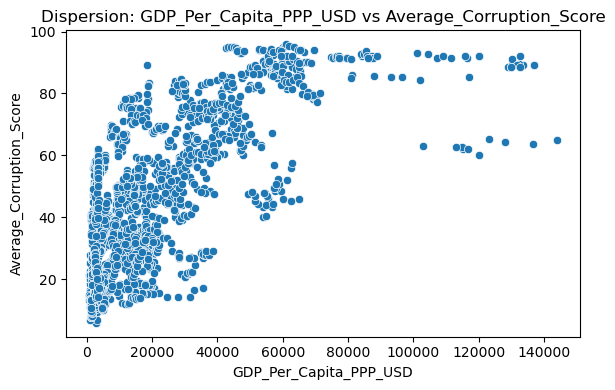

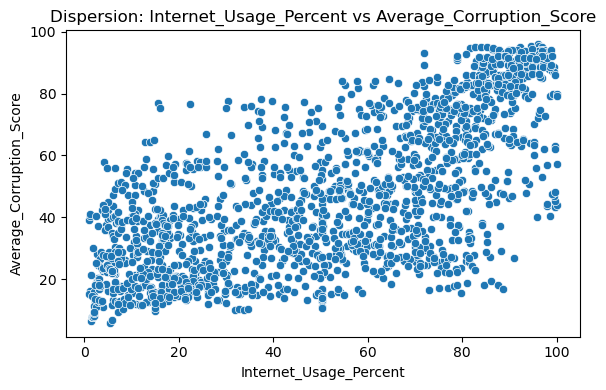

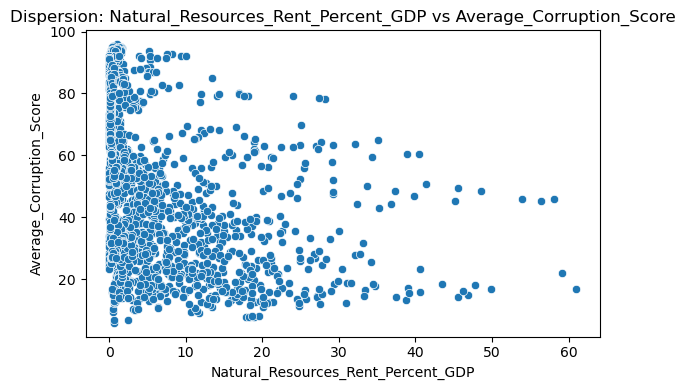

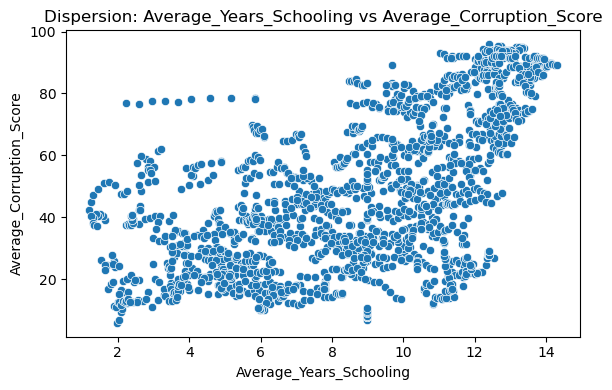

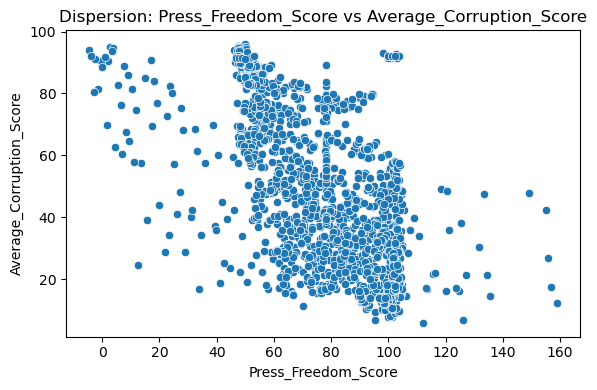

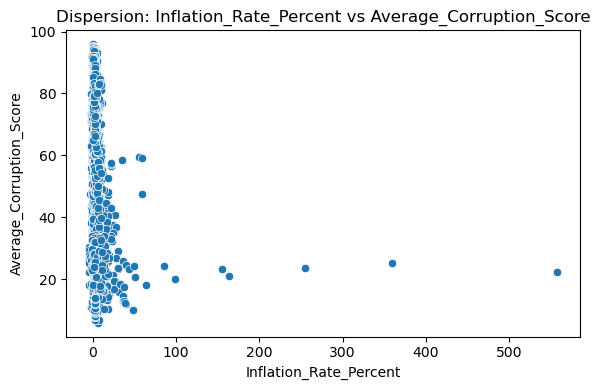

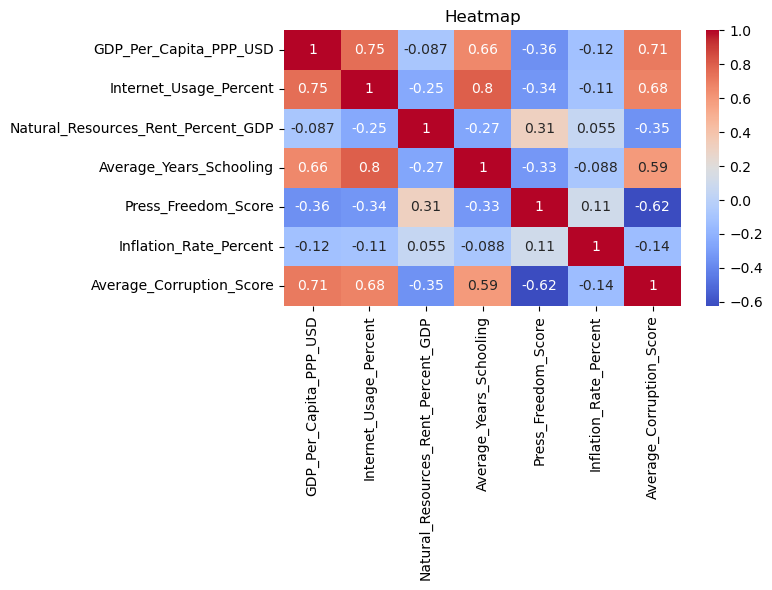

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el dataset
df = pd.read_csv('../data/processed/corruption_dataset_imputed_inflation_category.csv')

# Características relevantes
features = [
    'GDP_Per_Capita_PPP_USD',
    'Internet_Usage_Percent',
    'Natural_Resources_Rent_Percent_GDP',
    'Average_Years_Schooling',
    'Press_Freedom_Score',
    'Inflation_Rate_Percent'
]
target = 'Average_Corruption_Score'

# Gráficos de dispersión
for feature in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=df, x=feature, y=target)
    plt.title(f'Dispersion: {feature} vs {target}')
    plt.tight_layout()
    plt.show()

# Mapa de calor de la correlación
plt.figure(figsize=(8,6))
corr = df[features + [target]].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Heatmap')
plt.tight_layout()
plt.show()


### Key insights:

**GDP per capita and corruption has a strong logarithmic correlation which aligns with general theories**

📈 High GDP → Less Corruption

Countries with higher GDP per capita tend to have more resources to fund education, justice, and strong institutions.

Being wealthier, the population relies less on corruption as a means of survival (for example, paying bribes to access basic services).

Incentives change: in wealthy economies, losing reputation or an institutional position can cost more than what is gained through corrupt practices.

📉 Corruption → Lower GDP

Corruption diverts public resources to private interests.

It hinders foreign investment and innovation (because it increases "hidden costs").

It destroys infrastructure (through inflated or poorly executed contracts) and limits human capital (less investment in education and health).

🔄 Circular Relationship

The model and the general theory point to a bidirectional relationship:

More wealth can reduce corruption (if accompanied by institutions and transparency).

More corruption hinders wealth (because it erodes growth).

↗️ Logarithmic correlation

In poor countries, a small increase in GDP per capita can already make a big difference in corruption: more schools, more internet access, a little more institutionality. The curve grows rapidly at first.

But as GDP grows, the country eventually quits the vicious circle and each additional increase has a decreasing effect on corruption. An already wealthy economy doesn't "clean up" much further because residual problems depend on political, cultural, or institutional factors that can't be solved with money alone. The curve flattens.

📡 **Internet and corruption (r = 0.69, positive, high dispersion)**

Greater internet use is often associated with lower perceived corruption. The high dispersion shows that the internet alone is not enough: there are countries with widespread internet access but weak institutions where corruption remains high.

🎓 **Education and corruption (r = 0.59, positive, high dispersion)**

More average years of schooling tend to be related to lower levels of corruption. The relationship is clear, but not decisive: education generates more critical citizens capable of demanding transparency, although it does not always translate into immediate institutional change.

📰 **Freedom of the press and corruption (r = –0.62, negative, high dispersion)**

Here, the negative correlation is strong: less press freedom → more corruption. Even so, the dispersion shows that the relationship is not perfect. In some authoritarian regimes, corruption remains hidden rather than reduced, which introduces noise.

***The high dispersion in correlations can also be explained by the fact that corruption is a phenomenon measured abstractly, through perception indices and qualitative assessments, rather than exact figures. This inevitably introduces a certain degree of subjectivity and variability, unlike more concrete indicators such as the percentage of the population with internet access.***

⛏️ **Natural resource rent (as a % of GDP) and corruption (r = –0.35, negative)**

Greater resource dependence is often associated with greater corruption (although the correlation is not as high). This fits with the "resource curse" theory: easy rents create incentives to capture the state and weaken institutions. The relationship might be more complex: high resouce rent → high corrption because the government corrupts institutions for usurpation of power, while extremely high resouce rent may have the opposite effect as the money flows in country's development: GDP growth, education, technologies.

⛏️ **Natural resource rent and press freedom (r = 0.31, positive)**

A curious finding: greater resource dependence correlates with less press freedom. This is probably because governments with control over strategic resources tend to concentrate power and limit the critical role of the media.

📈 **Inflation and corruption (r = –0.14, negative, weak)**

Inflation, by showing a very weak correlation with corruption, appears to be too noisy an indicator to capture the structural stability of the economy. It rather reflects cyclical or short-term factors such as price shocks, external shocks, or monetary policies and is therefore insufficient on its own to assess institutional soundness or the presence of corruption.

**For modeling:**

The scatter between GDP Per Capita and the target shows a nonlinear relationship. This motivates the use of models that can capture nonlinearities (RandomForest, GradientBoosting) or the addition of polynomial features to linear models.

The scatter also shows several outliers in Inflation Rate; these affect the mean and scale-sensitive algorithms (LR, KNN). We can use Robust Scaler for outlier-sensitive models and/or winsorize/trim for outliers before training.

The heatmap shows a strong correlation (0.8) between GDP Per Capita and Average Year Schooling. This indicates multicollinearity. We can apply regularization (L2) in linear models to reduce the variance of the estimates.



### Opportunities for feature engineering:

- Logarithm GDP per capita or create categories (very low / low / medium / high) since the relatioship is non-linear
- Multiply press freedom and natural resources rent to explore the "resource curse"
- Add unemployment rate and group with to inflation to create better 'economic stability' category

*Ethical Risk:* Some features (e.g. Press Freedom) can act as a proxy for geopolitics or economic performance, leading to a "penalization" of countries in certain regions.

*Mitigation Strategy:* Check VIFs and correlations, remove/regularize highly correlated features to ensure that predictions are not driven by a single, problematic variable.

*Trade-off:* Removing informative features reduces model accuracy but reduces the risk of unfairly discriminating against countries whose indices are formed subjectively.


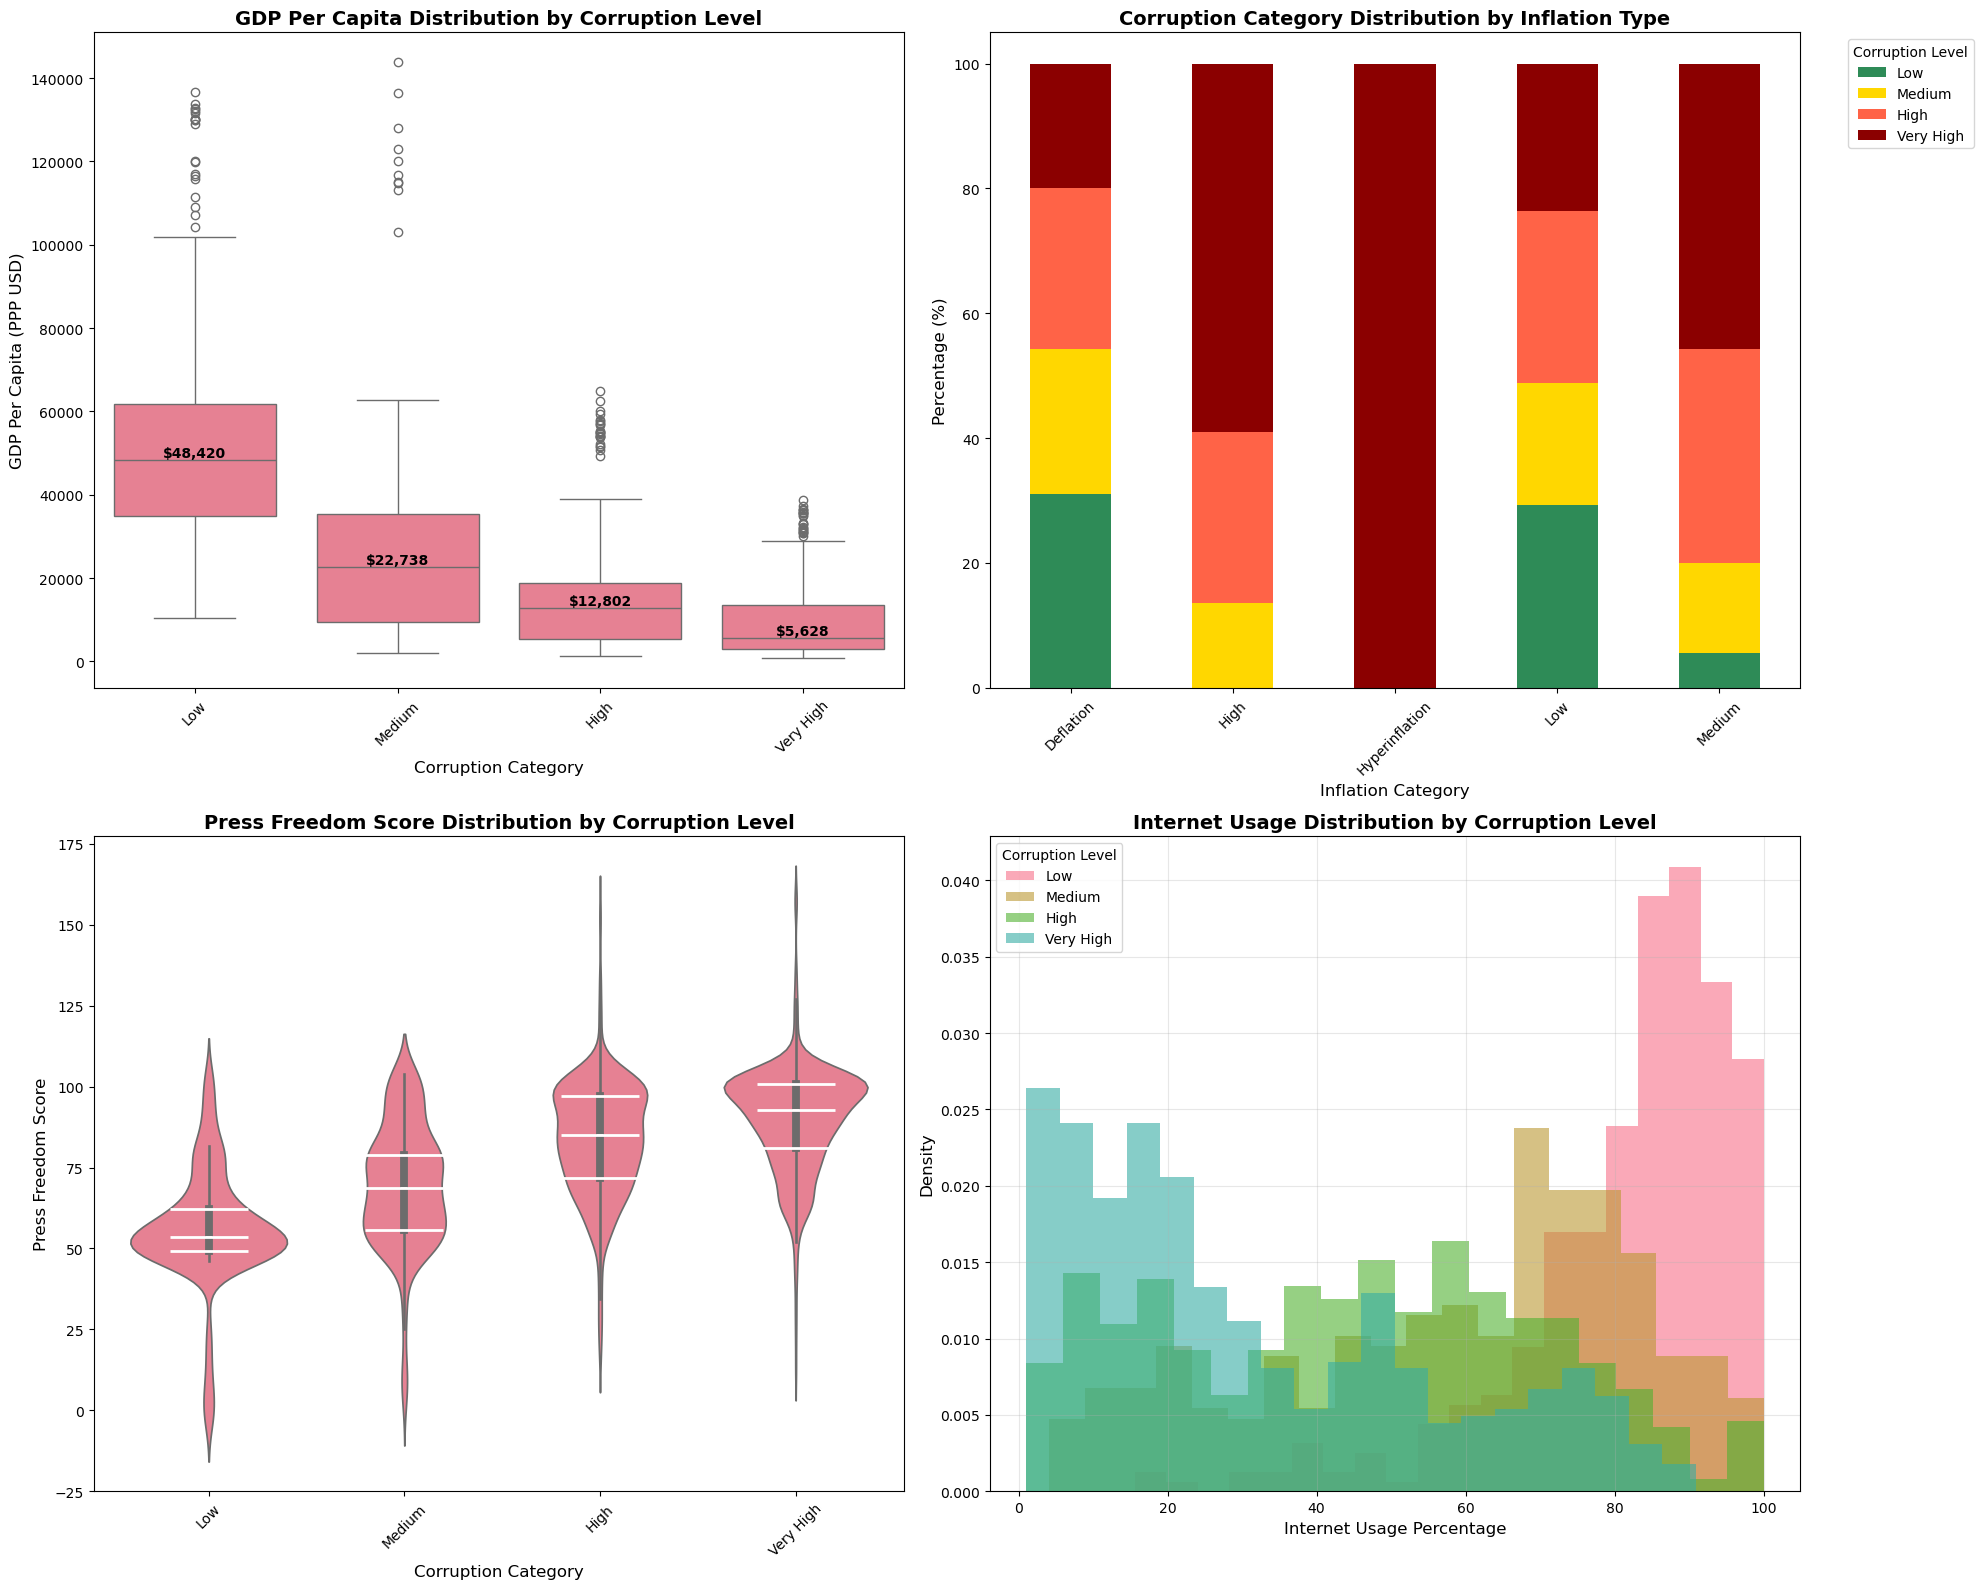

=== STATISTICAL INSIGHTS FOR INTERPRETATIONS ===

1. GDP BOXPLOT INSIGHTS:
                           median           std  count
Corruption_Category                                   
High                 12801.640853  12337.778702    481
Low                  48419.643251  25439.345090    377
Medium               22737.572941  23446.827613    307
Very High             5628.459223   8275.659651    498
Coefficient of variation by corruption level:
Low: 0.497
Medium: 0.911
High: 0.854
Very High: 0.928

2. CLASS DISTRIBUTION INSIGHTS:
Cross-tabulation (counts):
Corruption_Category  High  Low  Medium  Very High
Inflation_Category                               
Deflation              40   48      36         31
High                   12    0       6         26
Hyperinflation          0    0       0          5
Low                   287  306     205        247
Medium                142   23      60        189

Chi-square test for independence:
Chi-square statistic: 177.840, p-value: 0.000000



In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load and examine the dataset
df = pd.read_csv('../data/processed/corruption_dataset_imputed_inflation_category.csv')

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")
fig = plt.figure(figsize=(20, 16))

# 1. BOXPLOT: GDP distribution across corruption categories
plt.subplot(2, 2, 1)
box_plot = sns.boxplot(data=df, x='Corruption_Category', y='GDP_Per_Capita_PPP_USD', 
                       order=['Low', 'Medium', 'High', 'Very High'])
plt.title('GDP Per Capita Distribution by Corruption Level', fontsize=14, fontweight='bold')
plt.xlabel('Corruption Category', fontsize=12)
plt.ylabel('GDP Per Capita (PPP USD)', fontsize=12)
plt.xticks(rotation=45)

# Add median values as text
medians = df.groupby('Corruption_Category')['GDP_Per_Capita_PPP_USD'].median()
for i, category in enumerate(['Low', 'Medium', 'High', 'Very High']):
    plt.text(i, medians[category], f'${medians[category]:,.0f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()

# 2. CLASS DISTRIBUTION: Stacked bar chart of corruption categories by inflation category
plt.subplot(2, 2, 2)
crosstab = pd.crosstab(df['Inflation_Category'], df['Corruption_Category'], normalize='index') * 100
crosstab_ordered = crosstab[['Low', 'Medium', 'High', 'Very High']]
ax2 = crosstab_ordered.plot(kind='bar', stacked=True, ax=plt.gca(), 
                           color=['#2E8B57', '#FFD700', '#FF6347', '#8B0000'])
plt.title('Corruption Category Distribution by Inflation Type', fontsize=14, fontweight='bold')
plt.xlabel('Inflation Category', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(title='Corruption Level', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)

# 3. VIOLIN PLOT: Distribution of Press Freedom Score by Corruption Category
plt.subplot(2, 2, 3)
violin_plot = sns.violinplot(data=df, x='Corruption_Category', y='Press_Freedom_Score',
                            order=['Low', 'Medium', 'High', 'Very High'])
plt.title('Press Freedom Score Distribution by Corruption Level', fontsize=14, fontweight='bold')
plt.xlabel('Corruption Category', fontsize=12)
plt.ylabel('Press Freedom Score', fontsize=12)
plt.xticks(rotation=45)

# Add quartile lines
for i, category in enumerate(['Low', 'Medium', 'High', 'Very High']):
    quartiles = df[df['Corruption_Category'] == category]['Press_Freedom_Score'].quantile([0.25, 0.5, 0.75])
    plt.hlines(quartiles, i-0.2, i+0.2, colors='white', linestyles='solid', linewidth=2)

# 4. HISTOGRAM WITH KDE: Internet Usage distribution with corruption overlay
plt.subplot(2, 2, 4)
for category in ['Low', 'Medium', 'High', 'Very High']:
    subset = df[df['Corruption_Category'] == category]['Internet_Usage_Percent']
    plt.hist(subset, alpha=0.6, label=category, bins=20, density=True)
    
plt.title('Internet Usage Distribution by Corruption Level', fontsize=14, fontweight='bold')
plt.xlabel('Internet Usage Percentage', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend(title='Corruption Level')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistical insights for interpretations
print("=== STATISTICAL INSIGHTS FOR INTERPRETATIONS ===\n")

print("1. GDP BOXPLOT INSIGHTS:")
gdp_stats = df.groupby('Corruption_Category')['GDP_Per_Capita_PPP_USD'].agg(['median', 'std', 'count'])
print(gdp_stats)
print(f"Coefficient of variation by corruption level:")
for cat in ['Low', 'Medium', 'High', 'Very High']:
    cv = df[df['Corruption_Category'] == cat]['GDP_Per_Capita_PPP_USD'].std() / df[df['Corruption_Category'] == cat]['GDP_Per_Capita_PPP_USD'].mean()
    print(f"{cat}: {cv:.3f}")

print("\n2. CLASS DISTRIBUTION INSIGHTS:")
print("Cross-tabulation (counts):")
print(pd.crosstab(df['Inflation_Category'], df['Corruption_Category']))
print("\nChi-square test for independence:")
chi2, p_value, dof, expected = stats.chi2_contingency(pd.crosstab(df['Inflation_Category'], df['Corruption_Category']))
print(f"Chi-square statistic: {chi2:.3f}, p-value: {p_value:.6f}")

print("\n3. PRESS FREEDOM VIOLIN PLOT INSIGHTS:")
press_stats = df.groupby('Corruption_Category')['Press_Freedom_Score'].agg(['mean', 'std', 'skew'])
print(press_stats)

print("\n4. INTERNET USAGE HISTOGRAM INSIGHTS:")
internet_stats = df.groupby('Corruption_Category')['Internet_Usage_Percent'].agg(['mean', 'std', 'skew'])
print(internet_stats)
print("\nKolmogorov-Smirnov test between Low and Very High corruption:")
low_internet = df[df['Corruption_Category'] == 'Low']['Internet_Usage_Percent']
very_high_internet = df[df['Corruption_Category'] == 'Very High']['Internet_Usage_Percent']
ks_stat, ks_p = stats.ks_2samp(low_internet, very_high_internet)
print(f"KS statistic: {ks_stat:.3f}, p-value: {ks_p:.6f}")

**GDP per capita boxplot**

The boxplot demonstrates countries with low levels of corruption have a median GDP of $48,420, compared to $5,628 in countries with very high levels of corruption. The coefficient of variation is lowest in countries with low levels of corruption (0.497), indicating more stable economic performance, while countries with high levels of corruption exhibit greater variability (0.911–0.928).

**Distribution of corruption by inflation category. Stacked bar chart**

The stacked bar chart shows a significant class imbalance in the combinations of inflation and corruption: "low" inflation dominates most corruption categories, but exhibits different distributions. Hyperinflationary countries fall exclusively into the "very high" corruption category, while deflationary countries exhibit a more balanced distribution of corruption. 

Option 1 (already meantioned): unite with unemployment rate to create new economic stability catergory

Option 2: use of stratified sampling, SMOTE, or cost-sensitive learning algorithms, as well as the choice of metrics such as the F1 score or AUC-ROC, rather than accuracy, to correctly assess model performance across all classes.

**Violin plot of press freedom scores by corruption level**
The violin plots show distribution shapes and central tendencies: countries with low levels of corruption have lower press freedom scores (mean = 55.95, indicating higher levels of press freedom) and negative skewness (-0.49), while countries with very high levels of corruption exhibit higher scores (mean = 89.74) with a similar negative skewness (-0.52). Violin plots indicate potential multimodality in some categories, suggesting the presence of subpopulations within corruption levels. 

Overlapping distributions and different shapes indicate that press freedom alone may not be sufficient for classification, requiring the use of ensemble methods or feature engineering (e.g., press freedom quartiles) to capture nonlinear relationships and improve discriminatory power.

**Distribution of Internet Use by Corruption Level**
The overlapping histograms reveal significantly different distributions: countries with low corruption levels exhibit strong negative skewness (-1.70) and high mean usage (81.7%), while countries with very high corruption levels exhibit positive skewness (0.73) and significantly lower usage (30.9%). 

The Kolmogorov-Smirnov test confirms that these distributions are significantly different (KS = 0.764, p < 0.001). 

The significant differences in distributions and high discriminatory power (KS statistic) make internet use an excellent feature for classification, but skewed distributions suggest the use of power-law transformations or tree-based models, which handle non-normal distributions better than linear classifiers.

**Modeling relationships:**

- Strong monotonic relationships exist, but with different functional forms, requiring different transformation strategies.
- Multicollinearity issues: GDP and internet use are likely highly correlated, suggesting the need for regularization (Ridge/Lasso method) or dimensionality reduction.
- High variance in corrupt countries indicates sensitivity to outliers, making robust algorithms such as Random Forest preferable to linear models.


| Preprocessing Step | Code Implementation | Motivation |
|---|---:|---|
| Encoding | OneHotEncoder(handle_unknown='ignore') | Suitable for categories without ordinal order, compatible with linear and tree models |
| Scaling | StandardScaler/RobustScaler | Standard for models with regularization; Robust for outlier-sensitive problems |
| Balancing | SMOTE in the pipeline | Reduces metric bias for imbalanced classes |
| Outlier Handling | Winsorization (1%) | Reduces the impact of extreme values on sensitive models |
| Feature Selection | VIF  | Remove multicollinearity and reduce dimensionality (lower variance) |


# Creating suggested features

First, let's add unemployment rates column, considering all the previously mentioned nuances: standardizing country names, filling missing values avoiding data leakage

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Load both datasets
corruption_df = pd.read_csv('../data/processed/corruption_dataset_imputed_inflation_category.csv')
unemployment_df = pd.read_csv('../data/raw/unemplotment-rates.csv')

total_unemployment = unemployment_df[unemployment_df['Series Code'] == 'SL.UEM.TOTL.ZS'].copy()
print(f"\nTotal unemployment data shape: {total_unemployment.shape}")

# Check for missing values in unemployment data
year_columns = [col for col in total_unemployment.columns if '[YR' in col]
print(f"\nYear columns: {year_columns}")

# Convert year columns to numeric and check missing values
for col in year_columns:
    total_unemployment[col] = pd.to_numeric(total_unemployment[col], errors='coerce')

print("\nMissing values in unemployment data:")
for col in year_columns:
    missing = total_unemployment[col].isna().sum()
    print(f"{col}: {missing} missing values")

# Reshape unemployment data from wide to long format
unemployment_long = pd.melt(
    total_unemployment, 
    id_vars=['Country Name', 'Country Code'], 
    value_vars=year_columns,
    var_name='Year_Col', 
    value_name='Unemployment_Rate'
)

# Extract year from column name
unemployment_long['Year'] = unemployment_long['Year_Col'].str.extract(r'(\d{4})').astype(int)

unemployment_long = unemployment_long.drop('Year_Col', axis=1)

# Remove rows with missing unemployment rates for now (we'll handle this later)
print(f"Unemployment data before removing NaN: {len(unemployment_long)}")
unemployment_clean = unemployment_long.dropna(subset=['Unemployment_Rate']).copy()
print(f"Unemployment data after removing NaN: {len(unemployment_clean)}")

print("\nSample of reshaped unemployment data:")
print(unemployment_clean.head())

# Compare country names between datasets
corruption_countries = set(corruption_df['Country'].unique())
unemployment_countries = set(unemployment_clean['Country Name'].unique())

print(f"\nCountries in corruption dataset: {len(corruption_countries)}")
print(f"Countries in unemployment dataset: {len(unemployment_countries)}")
print(f"Common countries: {len(corruption_countries.intersection(unemployment_countries))}")

# Find countries that don't match
corruption_only = corruption_countries - unemployment_countries
unemployment_only = unemployment_countries - corruption_countries

print(f"\nCountries only in corruption dataset: {len(corruption_only)}")
print("Sample:", list(corruption_only)[:10])

print(f"\nCountries only in unemployment dataset: {len(unemployment_only)}")
print("Sample:", list(unemployment_only)[:10])

# Create a mapping for country name standardization
country_mapping = {
    # Common name variations
    'Egypt, Arab Rep.': 'Egypt',
    'Russian Federation': 'Russia',
    'Turkiye': 'Turkey',
    'Iran, Islamic Rep.': 'Iran',
    'Congo, Dem. Rep.': 'Democratic Republic of Congo',
    'Cote d\'Ivoire': 'Ivory Coast',
    'Korea, Rep.': 'South Korea',
    'Korea, Dem. People\'s Rep.': 'North Korea',
    'Venezuela, RB': 'Venezuela',
    'Syrian Arab Republic': 'Syria',
    'Yemen, Rep.': 'Yemen',
    'Lao PDR': 'Laos',
    'Slovak Republic': 'Slovakia',
    'Czech Republic': 'Czechia',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Congo, Rep.': 'Republic of Congo',
    'Gambia, The': 'Gambia',
    'Bahamas, The': 'Bahamas',
    'Viet Nam': 'Vietnam',
    'Myanmar': 'Burma',
    'North Macedonia': 'Macedonia',
    'Eswatini': 'Swaziland'
}

# Apply mapping to unemployment data
unemployment_clean['Country_Standardized'] = unemployment_clean['Country Name'].replace(country_mapping)

# Check matches after standardization
unemployment_countries_std = set(unemployment_clean['Country_Standardized'].unique())
common_after_mapping = corruption_countries.intersection(unemployment_countries_std)

print(f"Common countries after mapping: {len(common_after_mapping)}")

# Find remaining mismatches
corruption_only_after = corruption_countries - unemployment_countries_std
unemployment_only_after = unemployment_countries_std - corruption_countries

print(f"\nCountries still only in corruption dataset: {len(corruption_only_after)}")
print("List:", sorted(list(corruption_only_after)))

print(f"\nCountries still only in unemployment dataset: {len(unemployment_only_after)}")
print("Sample:", sorted(list(unemployment_only_after))[:15])

# Add more mappings for the remaining countries
additional_mapping = {
    'Cabo Verde': 'Cape Verde',
    'Macedonia': 'North Macedonia',
    'Burma': 'Myanmar',
    'Eswatini': 'Eswatini'  # This one might not match due to timing of name change
}

# Update the mapping
country_mapping.update(additional_mapping)

# Apply updated mapping
unemployment_clean['Country_Standardized'] = unemployment_clean['Country Name'].replace(country_mapping)

# Check final matches
unemployment_countries_final = set(unemployment_clean['Country_Standardized'].unique())
common_final = corruption_countries.intersection(unemployment_countries_final)

print(f"Final common countries: {len(common_final)}")

# Prepare unemployment data for merging
unemployment_for_merge = unemployment_clean[['Country_Standardized', 'Year', 'Unemployment_Rate']].copy()
unemployment_for_merge.rename(columns={'Country_Standardized': 'Country'}, inplace=True)

print(f"\nUnemployment data ready for merge: {unemployment_for_merge.shape}")
print("Sample:")
print(unemployment_for_merge.head())

# Check year ranges
print(f"\nYear range in unemployment data: {unemployment_for_merge['Year'].min()} - {unemployment_for_merge['Year'].max()}")
print(f"Year range in corruption data: {corruption_df['Year'].min()} - {corruption_df['Year'].max()}")

# Check data availability by year
print("\nData availability by year:")
for year in sorted(unemployment_for_merge['Year'].unique()):
    count = len(unemployment_for_merge[unemployment_for_merge['Year'] == year])
    print(f"{year}: {count} countries")

# Merge the datasets
merged_df = corruption_df.merge(
    unemployment_for_merge, 
    on=['Country', 'Year'], 
    how='left'
)

print(f"Merged dataset shape: {merged_df.shape}")
print(f"Missing unemployment rates after merge: {merged_df['Unemployment_Rate'].isna().sum()}")

# Implement train/test split based on years (8 years training, 2 years testing)
# Training: 2012-2019 (8 years)
# Testing: 2020-2021 (2 years)

train_df = merged_df[merged_df['Year'] <= 2019].copy()
test_df = merged_df[merged_df['Year'] >= 2020].copy()

print(f"\nTrain set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"Train years: {sorted(train_df['Year'].unique())}")
print(f"Test years: {sorted(test_df['Year'].unique())}")

# Check missing unemployment rates in each set
print(f"\nMissing unemployment rates in train set: {train_df['Unemployment_Rate'].isna().sum()}")
print(f"Missing unemployment rates in test set: {test_df['Unemployment_Rate'].isna().sum()}")

# Analyze missing data patterns
print("\nMissing unemployment data by country (train set):")
missing_by_country_train = train_df[train_df['Unemployment_Rate'].isna()]['Country'].value_counts()
print(f"Countries with missing data: {len(missing_by_country_train)}")
print("Top 10 countries with most missing data:")
print(missing_by_country_train.head(10))

# Function to impute missing values following the rules
def impute_unemployment_training(df):
    """
    Impute missing unemployment values in training set using only past/same year data
    """
    df_imputed = df.copy()
    
    # Sort by country and year for easier processing
    df_imputed = df_imputed.sort_values(['Country', 'Year'])
    
    # For each country, fill missing values using forward fill (past values)
    df_imputed['Unemployment_Rate'] = df_imputed.groupby('Country')['Unemployment_Rate'].fillna(method='ffill')
    
    # For remaining missing values (at the beginning of time series), use regional/global median
    # Calculate median unemployment rate by year for countries with data
    yearly_medians = df_imputed.groupby('Year')['Unemployment_Rate'].median()
    
    # Fill remaining missing values with yearly median
    for year in df_imputed['Year'].unique():
        mask = (df_imputed['Year'] == year) & (df_imputed['Unemployment_Rate'].isna())
        df_imputed.loc[mask, 'Unemployment_Rate'] = yearly_medians[year]
    
    return df_imputed

# Apply imputation to training set
train_df_imputed = impute_unemployment_training(train_df)

print(f"Missing unemployment rates in train set after imputation: {train_df_imputed['Unemployment_Rate'].isna().sum()}")

# Calculate statistics from training set for test set imputation
train_stats = {
    'country_medians': train_df_imputed.groupby('Country')['Unemployment_Rate'].median(),
    'yearly_medians': train_df_imputed.groupby('Year')['Unemployment_Rate'].median(),
    'overall_median': train_df_imputed['Unemployment_Rate'].median()
}

print(f"\nTraining set statistics calculated:")
print(f"Countries with median unemployment rates: {len(train_stats['country_medians'])}")
print(f"Overall median unemployment rate: {train_stats['overall_median']:.2f}%")

# Show which countries had missing data and how they were imputed
missing_countries = ['Myanmar', 'Kosovo', 'North Macedonia', 'Seychelles', 'Dominica', 'Grenada']
for country in missing_countries[:3]:  # Show first 3 as example
    country_data = train_df_imputed[train_df_imputed['Country'] == country][['Year', 'Unemployment_Rate']].sort_values('Year')
    print(f"\n{country} unemployment rates after imputation:")
    print(country_data)

# Function to impute missing values in test set using only training set statistics
def impute_unemployment_testing(test_df, train_stats):
    """
    Impute missing unemployment values in test set using only training set statistics
    """
    df_imputed = test_df.copy()
    
    # Sort by country and year
    df_imputed = df_imputed.sort_values(['Country', 'Year'])
    
    # For each missing value, try different imputation strategies in order:
    # 1. Use country median from training set
    # 2. Use overall median from training set
    
    for idx, row in df_imputed.iterrows():
        if pd.isna(row['Unemployment_Rate']):
            country = row['Country']
            
            # Strategy 1: Use country median from training set
            if country in train_stats['country_medians']:
                df_imputed.loc[idx, 'Unemployment_Rate'] = train_stats['country_medians'][country]
            else:
                # Strategy 2: Use overall median from training set
                df_imputed.loc[idx, 'Unemployment_Rate'] = train_stats['overall_median']
    
    return df_imputed

# Apply imputation to test set
test_df_imputed = impute_unemployment_testing(test_df, train_stats)

print(f"Missing unemployment rates in test set after imputation: {test_df_imputed['Unemployment_Rate'].isna().sum()}")

# Show test set imputation results for countries that had missing data
test_missing_countries = test_df[test_df['Unemployment_Rate'].isna()]['Country'].unique()
print(f"\nCountries with missing data in test set: {list(test_missing_countries)}")

for country in test_missing_countries[:3]:  # Show first 3 as example
    country_data = test_df_imputed[test_df_imputed['Country'] == country][['Year', 'Unemployment_Rate']].sort_values('Year')
    print(f"\n{country} unemployment rates in test set after imputation:")
    print(country_data)
    
    # Show what training median was used
    if country in train_stats['country_medians']:
        print(f"Used country median from training: {train_stats['country_medians'][country]:.4f}")
    else:
        print(f"Used overall median from training: {train_stats['overall_median']:.4f}")

# Combine train and test sets
final_df = pd.concat([train_df_imputed, test_df_imputed], ignore_index=True)
final_df = final_df.sort_values(['Country', 'Year'])

print(f"\nFinal dataset shape: {final_df.shape}")
print(f"Missing unemployment rates in final dataset: {final_df['Unemployment_Rate'].isna().sum()}")

# Show summary statistics
print(f"\nFinal dataset summary:")
print(f"Countries: {final_df['Country'].nunique()}")
print(f"Years: {sorted(final_df['Year'].unique())}")
print(f"Total records: {len(final_df)}")
print(f"Records with unemployment data: {final_df['Unemployment_Rate'].notna().sum()}")

print("\nUnemployment rate statistics:")
print(final_df['Unemployment_Rate'].describe())

# Create the final dataset with unemployment rates added
final_columns = [
    'Country', 'Year', 'GDP_Per_Capita_PPP_USD', 'Inflation_Category', 'Inflation_Rate_Percent',
    'Internet_Usage_Percent', 'Natural_Resources_Rent_Percent_GDP', 
    'Average_Years_Schooling', 'Press_Freedom_Score', 'Unemployment_Rate',
    'Corruption_Category', 'Average_Corruption_Score'
]

final_dataset = final_df[final_columns].copy()

# Verify the dataset
print("Final Dataset Summary:")
print(f"Shape: {final_dataset.shape}")
print(f"Columns: {list(final_dataset.columns)}")
print("\nFirst few rows:")
print(final_dataset.head())

print("\nData types:")
print(final_dataset.dtypes)

print("\nMissing values check:")
print(final_dataset.isnull().sum())

# Save the final dataset
final_dataset.to_csv('../data/processed/corruption_dataset_with_unemployment.csv', index=False)
print("\nDataset saved as 'corruption_dataset_with_unemployment.csv'")

# Create a summary of the imputation process
imputation_summary = {
    'total_records': len(final_dataset),
    'countries': final_dataset['Country'].nunique(),
    'years': f"{final_dataset['Year'].min()}-{final_dataset['Year'].max()}",
    'train_test_split': 'Years 2012-2019 (training), 2020-2021 (testing)',
    'missing_values_imputed': 55,
    'imputation_strategy_train': 'Forward fill within country, then yearly median',
    'imputation_strategy_test': 'Country median from training set, then overall median',
    'unemployment_rate_range': f"{final_dataset['Unemployment_Rate'].min():.1f}% - {final_dataset['Unemployment_Rate'].max():.1f}%",
    'unemployment_rate_mean': f"{final_dataset['Unemployment_Rate'].mean():.2f}%"
}

print("\n" + "="*60)
print("IMPUTATION SUMMARY")
print("="*60)
for key, value in imputation_summary.items():
    print(f"{key.replace('_', ' ').title()}: {value}")

# Show some examples of countries with complete vs imputed data
print("\n" + "="*60)
print("EXAMPLES OF DATA QUALITY")
print("="*60)

# Countries with complete unemployment data
complete_data_countries = []
for country in final_dataset['Country'].unique():
    country_data = unemployment_for_merge[unemployment_for_merge['Country'] == country]
    if len(country_data) == 10:  # All years 2012-2021
        complete_data_countries.append(country)

print(f"Countries with complete unemployment data: {len(complete_data_countries)}")
print("Examples:", complete_data_countries[:5])

# Countries that required imputation
imputed_countries = ['Myanmar', 'Kosovo', 'North Macedonia', 'Seychelles', 'Dominica', 'Grenada']
print(f"\nCountries that required imputation: {len(imputed_countries)}")
print("List:", imputed_countries)


Total unemployment data shape: (218, 14)

Year columns: ['2012 [YR2012]', '2013 [YR2013]', '2014 [YR2014]', '2015 [YR2015]', '2016 [YR2016]', '2017 [YR2017]', '2018 [YR2018]', '2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]']

Missing values in unemployment data:
2012 [YR2012]: 30 missing values
2013 [YR2013]: 30 missing values
2014 [YR2014]: 30 missing values
2015 [YR2015]: 30 missing values
2016 [YR2016]: 30 missing values
2017 [YR2017]: 30 missing values
2018 [YR2018]: 30 missing values
2019 [YR2019]: 30 missing values
2020 [YR2020]: 30 missing values
2021 [YR2021]: 30 missing values
Unemployment data before removing NaN: 2180
Unemployment data after removing NaN: 1880

Sample of reshaped unemployment data:
  Country Name Country Code  Unemployment_Rate  Year
0        World          WLD           6.160185  2012
1  Afghanistan          AFG           7.856000  2012
2      Albania          ALB          13.376000  2012
3      Algeria          DZA          10.970000  2012
6       Angol

## Creating economic stability category

In [29]:
import pandas as pd
import numpy as np

def create_economic_stability_category(df):
    """
    Create Economic Stability category based on inflation rate and unemployment rate.
    
    Categories:
    - Stable: Low inflation (≤5%) AND low unemployment (≤7%)
    - Moderately_Unstable: Medium ranges that don't qualify as stable or unstable
    - Unstable: High inflation (>15%) OR high unemployment (>15%)
    
    Parameters:
    df: DataFrame with 'Inflation_Rate_Percent' and 'Unemployment_Rate' columns
    
    Returns:
    DataFrame with added 'Economic_Stability' column
    """
    
    # Create a copy to avoid modifying original data
    df_copy = df.copy()
    
    # Define thresholds based on data analysis
    inflation_low = 5.0      # Around 75th percentile
    inflation_high = 15.0    # Around 95th percentile
    unemployment_low = 7.0   # Around median + buffer
    unemployment_high = 15.0 # Around 90th percentile
    
    # Stable: Low inflation AND low unemployment
    stable_condition = (df_copy['Inflation_Rate_Percent'] <= inflation_low) & \
                      (df_copy['Unemployment_Rate'] <= unemployment_low)
    
    # Unstable: High inflation OR high unemployment
    unstable_condition = (df_copy['Inflation_Rate_Percent'] > inflation_high) | \
                        (df_copy['Unemployment_Rate'] > unemployment_high)
    
    # Apply categorization
    df_copy['Economic_Stability'] = 'Moderately_Unstable'  # Default
    df_copy.loc[stable_condition, 'Economic_Stability'] = 'Stable'
    df_copy.loc[unstable_condition, 'Economic_Stability'] = 'Unstable'
    
    return df_copy

# Load and process the data
df = pd.read_csv('../data/processed/corruption_dataset_with_unemployment.csv')
df_with_stability = create_economic_stability_category(df)

# Save the result
df_with_stability.to_csv('../data/processed/corruption_dataset_with_economic_stability.csv', index=False)